In [1]:
# Navigate to appropriate directory
import os
while os.path.split(os.getcwd())[1] != "merlin-optical-sar":
    os.chdir("..")
    if os.getcwd() == "/":
        raise ValueError()

In [12]:
from glob import glob
import os

import numpy as np
import torch
import matplotlib.pyplot as plt

from Dataset import *
from model import *
from utils import *

In [3]:
ROOT_DIR = os.getcwd()
basedir = ROOT_DIR + '/basedir'
datasetdir = ROOT_DIR

torch.manual_seed(2)

In [4]:
class ArgumentParser():
    def __init__(self, *args, **kwargs):
        pass
    
    def add_argument(self, *args, **kwargs):
        setattr(self, kwargs['dest'], kwargs['default'])
    
    def parse_args(self):
        return self

parser = ArgumentParser(description='')
parser.add_argument('--epoch', dest='epoch', type=int, default=30 , help='# of epoch')
parser.add_argument('--batch_size', dest='batch_size', type=int, default=12, help='# images in batch')
parser.add_argument('--val_batch_size', dest='val_batch_size', type=int, default=1, help='# images in batch')

parser.add_argument('--patch_size', dest='patch_size', type=int, default=256, help='# size of a patch')
parser.add_argument('--stride_size', dest='stride_size', type=int, default=64, help='# size of the stride')
parser.add_argument('--n_data_augmentation', dest='n_data_augmentation', type=int, default=1, help='# data aug techniques')
parser.add_argument('--lr', dest='lr', type=float, default=0.001, help='initial learning rate for adam')
parser.add_argument('--weight_decay', dest='weight_decay', type=float, default=0.001, help='weight decay for adam')

parser.add_argument('--use_gpu', dest='use_gpu', type=int, default=1, help='gpu flag, 1 for GPU and 0 for CPU')
parser.add_argument('--phase', dest='phase', default='train', help='train or test')
parser.add_argument('--checkpoint_dir', dest='ckpt_dir', default=basedir+"/saved_model",
                    help='models are saved here')

parser.add_argument('--sample_dir', dest='sample_dir', default=basedir+"/sample", help='sample are saved here')
parser.add_argument('--test_dir', dest='test_dir', default=basedir+"/test", help='test sample are saved here')
parser.add_argument('--eval_set', dest='eval_set', default=datasetdir+'/pourMVA/validation/', help='dataset for eval in training')
parser.add_argument('--test_set', dest='test_set', default=datasetdir+'/pourMVA/validation/', help='dataset for testing')
parser.add_argument('--training_set', dest='training_set', default=datasetdir+'/pourMVA/train/', help='dataset for training')
parser.add_argument('--device', dest='device', default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), help='gpu or cpu')

args = parser.parse_args()

In [6]:
torch.autograd.set_detect_anomaly(True)

def fit(model,train_loader,val_loader,epochs,lr_list,gn_list,eval_files,eval_set,checkpoint_folder):
  """ Fit the model according to the given evaluation data and parameters.

  Parameters
  ----------
  model : model as defined in main
  train_loader : Pytorch's DataLoader of training data
  val_loader : Pytorch's DataLoader of validation data
  lr_list : list of learning rates
  eval_files : .npy files used for evaluation in training
  eval_set : directory of dataset used for evaluation in training

  Returns
  ----------
  self : object
    Fitted estimator.

  """


  train_losses = []
  val_losses=[]
  history={}
  ckpt_files = glob(checkpoint_folder+"/checkpoint_*")
  if len(ckpt_files)==0:
      epoch_num = 0
      model.apply(init_weights)
      loss = 0.0
      print("[*] Not find pre-trained model! Start training froms scratch")
  else:
    max_file = max(ckpt_files, key=os.path.getctime)
    checkpoint = torch.load(max_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.train()
    epoch_num = checkpoint['epoch_num']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_list[epoch_num-1])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']

    print("[*] Model restored! Resume training from latest checkpoint at "+max_file)

  with torch.no_grad():
    image_num=0
    for batch in val_loader:
      val_loss=model.validation_step(batch,image_num,epoch_num,eval_files,eval_set,args.sample_dir)
      image_num=image_num+1

  start_time = time.time()
  for epoch in range(epoch_num,epochs):
      epoch_num=epoch_num+1
      print("\nEpoch", epoch_num)
      print("\nLearning rate", lr_list[epoch])
      print("\nGradient norm", gn_list[epoch])
      print("***************** \n")
      optimizer = torch.optim.Adam(model.parameters(), lr=lr_list[epoch])

      #Train
      for i, batch in enumerate(train_loader, 0):
            running_loss = 0.0

            optimizer.zero_grad()
            loss = model.training_step(batch,i)
            train_losses.append(loss)

            loss.backward()

            total_norm = 0
            for p in model.parameters():
                param_norm = p.grad.detach().data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            print(total_norm)

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gn_list[epoch])

            optimizer.step()

            #running_loss += loss.item()     # extract the loss value
            print('[%d, %5d] time: %4.4f, loss: %.3f' % (epoch_num, i + 1,time.time()-start_time, loss))
            # zero the loss
            running_loss = 0.0


      save_checkpoint(model,checkpoint_folder,epoch_num,optimizer,loss)
      with torch.no_grad():
        image_num=0
        for batch in val_loader:
            val_loss=model.validation_step(batch,image_num,epoch_num,eval_files,eval_set,args.sample_dir)
            image_num=image_num+1

            # val_losses.append(val_loss)

      # print('For epoch', epoch+1,'the last validation loss is :',val_losses)

  history["train_loss"]=train_losses
  history["validation_loss"]=val_losses
  # save current checkpoint

  return history



def denoiser_train(model,lr_list,gn_list):
  """ Runs the denoiser algorithm for the training and evaluation dataset

  Parameters
  ----------
  model : model as defined in main
  lr_list : list of learning rates

  Returns
  ----------
  history : list of both training and validation loss

  """
  # Prepare train DataLoader
  train_data = load_train_data(args.training_set, args.patch_size, args.batch_size, args.stride_size, args.n_data_augmentation) # range [0; 1]
  print(train_data.shape)
  train_dataset = Dataset(train_data)

  train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=args.batch_size,shuffle=True,drop_last=True)

  # Prepare Validation DataLoader
  eval_dataset = ValDataset(args.eval_set) # range [0; 1]
  eval_loader = torch.utils.data.DataLoader(eval_dataset,batch_size=args.val_batch_size,shuffle=False,drop_last=True)
  eval_files = glob(args.eval_set+'*.npy')
  
  return locals()

  # Train the model
  history =fit(model,train_loader,eval_loader,args.epoch,lr_list,gn_list,eval_files,args.eval_set,args.ckpt_dir)

  # Save the model
  save_model(model,args.ckpt_dir)
  print("\n model saved at :",args.ckpt_dir)
  return history

def denoiser_test(model):
    """ Runs the test denoiser algorithm

    Parameters
    ----------
    denoiser : model as defined in main

    Returns
    ----------

    """
    # Prepare Validation DataLoader
    test_dataset = ValDataset(args.test_set) # range [0; 1]
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=args.val_batch_size,shuffle=False,drop_last=True)
    test_files = glob(args.test_set+'*.npy')


    val_losses=[]
    ckpt_files = glob(args.ckpt_dir+"/checkpoint_*")
    if len(ckpt_files)==0:
        print("[*] Not find pre-trained model! ")
        return None

    else:
        max_file = max(ckpt_files, key=os.path.getctime)
        checkpoint = torch.load(max_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        #model.train()

        print("[*] Model restored! Start testing...")

        with torch.no_grad():
            image_num=0
            for batch in test_loader:
              print(image_num)
              model.test_step(batch,image_num,test_files,args.test_set,args.test_dir)
              image_num=image_num+1


def main():
  if not os.path.exists(args.ckpt_dir):
      os.makedirs(args.ckpt_dir)
  if not os.path.exists(args.sample_dir):
      os.makedirs(args.sample_dir)
  if not os.path.exists(args.test_dir):
      os.makedirs(args.test_dir)
  # learning rate list
  lr = args.lr * np.ones([args.epoch])
  lr[4:20] = lr[0]/10
  lr[20:] = lr[0]/100
  # gradient norm list
  gn = 1.0*np.ones([args.epoch])



  model = AE(args.batch_size,args.val_batch_size,args.device)
  model.to(args.device)

  if args.phase == 'train':
      return denoiser_train(model,lr,gn)
  elif args.phase == 'test':
      denoiser_test(model)
  else:
      print('[!]Unknown phase')
      exit(0)

In [7]:
loc = main()

number of training data 1
total patches = 24336 , batch size = 12, total batches = 2028
(24336, 256, 256, 2)


In [11]:
a = loc["train_data"]

In [26]:
a.shape

(24336, 256, 256, 2)

In [19]:
np.unravel_index(np.argmax(a[..., 0]), a.shape[:3])

(11546, 212, 223)

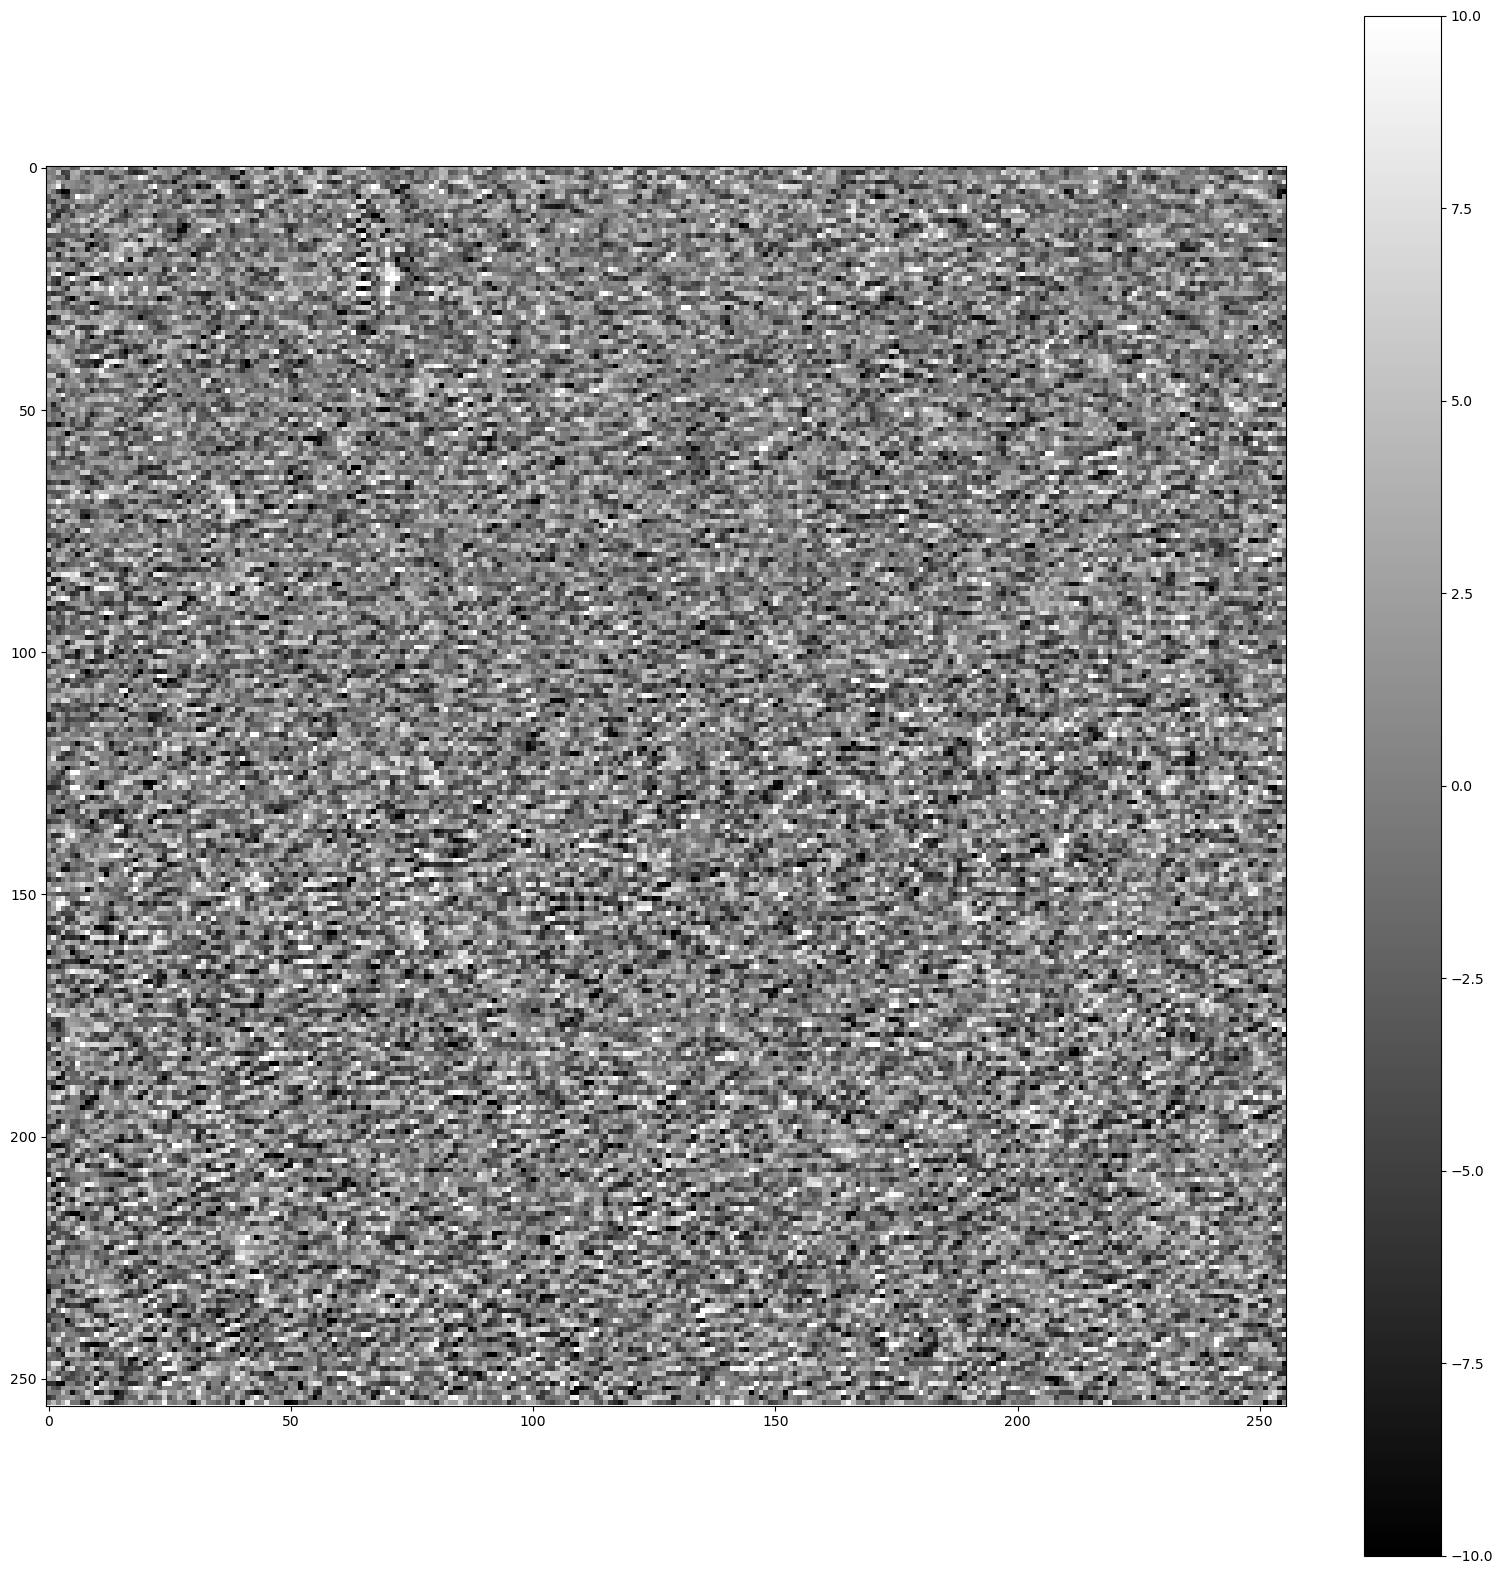

In [35]:
plt.figure(figsize=(20, 20))
plt.imshow(a[20100,...,0], cmap='gray', vmin=-10, vmax=10)
plt.colorbar()
plt.show()